# Push Bayesian Deep Learning Tutorial

## Introduction

In this notebook, we introduce Bayesian Deep Learning (BDL) and demonstrate how to use Push to perform BDL by running a deep ensemble.

## Background: The Posterior Predictive Distribution

The goal of BDL methods is to compute the *posterior predictive distribution*
$$
p(y|x, \mathcal{D}) = \int p(y|x, \theta) p(\theta | \mathcal{D}) \, d\theta
$$
where $y$ is an output, $x$ is an input, $\theta$ are parameters, and $\mathcal{D} = (x_i, y_i)_{i}$ is a dataset. In general, this integral is intractable and must be approximated.

### Monte Carlo Approximation

We can approximate the posterior predictive distribution with a Monte Carlo approximation [1]: 
$$
p(y|x, \mathcal{D}) \approx \frac{1}{J} \sum_{j=1}^{J} p(y|x, \theta_j), \quad \theta_j \sim p(\theta | D)
$$
where each $\theta_j$ corresponds to a unique parameter setting.

### Deep Ensembles

 *Deep ensembles* train $J$ different initializations of the same neural network (NN). If we average $p(y | x, \theta_j)$ over $J$ parameter settings $\theta_j$, we are essentially performing a Monte Carlo estimate that approximates the posterior predictive distribution. Thus, deep ensembles form a simple BDL method.

## Deep Ensembles in Push

We will now introduce deep ensembles in Push. Push interoperates with PyTorch, and so all datasets and models can use PyTorch components. Push also has concurrent execution semantics.

### Dataset

For illustrative purposes, we create a random dataset with $N$ points of dimension $D$.

In [1]:
from bdl import RandDataset
from bdl import SineDataset

D = 1
batch_size = 128
N = 4
dataset = SineDataset(batch_size, N, D, -2, 2)

```py
class RandDataset(Dataset):
    def __init__(self, batch_size, N, D):
        self.xs = torch.randn(batch_size*N, D)
        self.ys = torch.randn(batch_size*N, 1)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]


    
class SineDataset(Dataset):
    def __init__(self, batch_size, N, D, begin, end):
        self.xs = torch.linspace(begin * 3.1416, end * 3.1416, batch_size * N * D).reshape(batch_size * N, D)
        self.ys = torch.sin(self.xs[:, 0]).reshape(-1, 1)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

```

## Plotting the Dataset 

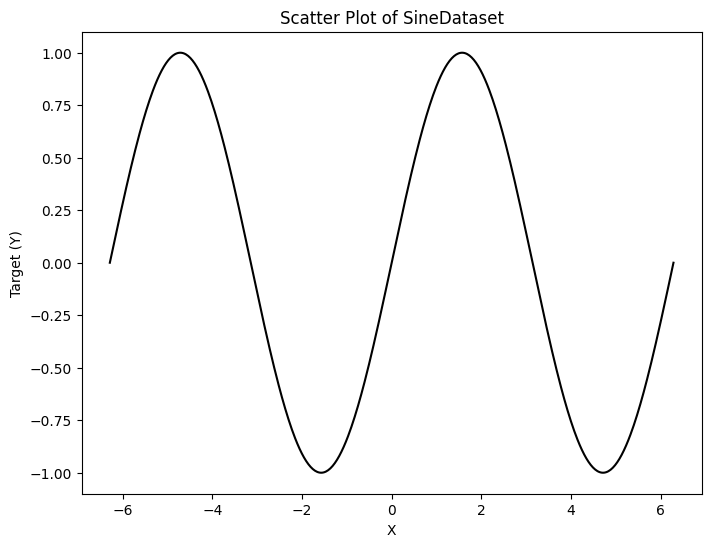

In [2]:
import matplotlib.pyplot as plt
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c ="black")
plt.title('Scatter Plot of SineDataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.show()

### Neural Network

We create a simple neural network (NN). This NN contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. 

In [3]:
from bdl import MiniNN
from bdl import BiggerNN

```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)

class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
```

### Training a Standard Neural Network (num_ensemble = 1)


In [4]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 100
num_ensembles = 1
n = 1
input_dim = 1
output_dim = 1
hidden_dim = 8
standard_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)
standard_params = standard_params[0]
standard_params[0]


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.9757)
Average loss 0 tensor(0.5351)
Average loss 0 tensor(0.4984)
Average loss 0 tensor(0.4130)
Average loss 0 tensor(0.3765)
Average loss 0 tensor(0.3648)
Average loss 0 tensor(0.3588)
Average loss 0 tensor(0.3489)
Average loss 0 tensor(0.3394)
Average loss 0 tensor(0.3412)
Average loss 0 tensor(0.3364)


  7%|▋         | 7/100 [00:00<00:05, 16.24it/s]

Average loss 0 tensor(0.3413)
Average loss 0 tensor(0.3401)
Average loss 0 tensor(0.3355)
Average loss 0 tensor(0.3354)
Average loss 0 tensor(0.3392)
Average loss 0 tensor(0.3388)
Average loss 0 tensor(0.3258)
Average loss 0 tensor(0.2716)
Average loss 0 tensor(0.2897)


 17%|█▋        | 17/100 [00:00<00:02, 29.60it/s]

Average loss 0 tensor(0.2569)
Average loss 0 tensor(0.2515)
Average loss 0 tensor(0.1874)
Average loss 0 tensor(0.1785)
Average loss 0 tensor(0.1543)
Average loss 0 tensor(0.3153)
Average loss 0 tensor(0.1977)
Average loss 0 tensor(0.2217)
Average loss 0 tensor(0.2060)


 27%|██▋       | 27/100 [00:01<00:02, 35.83it/s]

Average loss 0 tensor(0.1847)
Average loss 0 tensor(0.1937)
Average loss 0 tensor(0.1795)
Average loss 0 tensor(0.2057)
Average loss 0 tensor(0.1946)
Average loss 0 tensor(0.1765)
Average loss 0 tensor(0.1620)
Average loss 0 tensor(0.1684)
Average loss 0 tensor(0.2015)


 37%|███▋      | 37/100 [00:01<00:01, 39.20it/s]

Average loss 0 tensor(0.1780)
Average loss 0 tensor(0.1926)
Average loss 0 tensor(0.1687)
Average loss 0 tensor(0.1723)
Average loss 0 tensor(0.1694)
Average loss 0 tensor(0.1491)
Average loss 0 tensor(0.1638)
Average loss 0 tensor(0.1516)
Average loss 0 tensor(0.1785)


 47%|████▋     | 47/100 [00:01<00:01, 40.84it/s]

Average loss 0 tensor(0.1844)
Average loss 0 tensor(0.1907)
Average loss 0 tensor(0.1790)
Average loss 0 tensor(0.1688)
Average loss 0 tensor(0.1779)
Average loss 0 tensor(0.1573)
Average loss 0 tensor(0.1730)
Average loss 0 tensor(0.1551)
Average loss 0 tensor(0.1566)


 57%|█████▋    | 57/100 [00:01<00:01, 41.60it/s]

Average loss 0 tensor(0.1502)
Average loss 0 tensor(0.1495)
Average loss 0 tensor(0.1820)
Average loss 0 tensor(0.2016)
Average loss 0 tensor(0.1830)
Average loss 0 tensor(0.1941)
Average loss 0 tensor(0.1859)
Average loss 0 tensor(0.1620)
Average loss 0 tensor(0.1725)


 67%|██████▋   | 67/100 [00:01<00:00, 41.78it/s]

Average loss 0 tensor(0.1555)
Average loss 0 tensor(0.1493)
Average loss 0 tensor(0.1499)
Average loss 0 tensor(0.1526)
Average loss 0 tensor(0.1527)
Average loss 0 tensor(0.1826)
Average loss 0 tensor(0.1817)
Average loss 0 tensor(0.1617)
Average loss 0 tensor(0.1969)


 77%|███████▋  | 77/100 [00:02<00:00, 41.89it/s]

Average loss 0 tensor(0.1858)
Average loss 0 tensor(0.1720)
Average loss 0 tensor(0.1923)
Average loss 0 tensor(0.2072)
Average loss 0 tensor(0.1938)
Average loss 0 tensor(0.1887)
Average loss 0 tensor(0.1920)
Average loss 0 tensor(0.1790)
Average loss 0 tensor(0.1672)


 87%|████████▋ | 87/100 [00:02<00:00, 41.79it/s]

Average loss 0 tensor(0.1661)
Average loss 0 tensor(0.1534)
Average loss 0 tensor(0.1623)
Average loss 0 tensor(0.1536)
Average loss 0 tensor(0.1632)
Average loss 0 tensor(0.1593)
Average loss 0 tensor(0.1581)
Average loss 0 tensor(0.1665)
Average loss 0 tensor(0.1624)


100%|██████████| 100/100 [00:02<00:00, 36.47it/s]


Average loss 0 tensor(0.1615)
Average loss 0 tensor(0.1474)
Average loss 0 tensor(0.1599)
Average loss 0 tensor(0.1520)
Average loss 0 tensor(0.1529)
Average loss 0 tensor(0.1518)
Average loss 0 tensor(0.1475)
Average loss 0 tensor(0.1873)


tensor([[ 3.5940e-03],
        [ 5.7347e-03],
        [ 1.1265e-04],
        [-1.2252e-03],
        [ 1.5122e-02],
        [ 7.1184e-05],
        [-1.2121e-04],
        [-8.4584e-01]])

In the previous cell, we saved the output of our train_deep_ensemble function inside standard_params. train_deep_ensemble returns a list of all the parameters for each deep ensemble trained. Below we can see what these parameters look like. Since we are only training one model, the list will contain only one parameter setting.

In [5]:
standard_params

[tensor([[ 3.5940e-03],
         [ 5.7347e-03],
         [ 1.1265e-04],
         [-1.2252e-03],
         [ 1.5122e-02],
         [ 7.1184e-05],
         [-1.2121e-04],
         [-8.4584e-01]]),
 tensor([-5.3715e-04, -1.3278e-02,  1.5244e-03,  2.5394e-03, -3.5858e-02,
          2.5953e-05,  3.1284e-04,  1.2200e-01]),
 tensor([[-2.0202e-06,  7.9046e-05, -5.6371e-06, -1.0472e-05,  3.2123e-04,
          -3.2288e-06, -2.2554e-06, -1.8630e-04],
         [ 8.0151e-03,  2.0711e-02, -1.2773e-02, -4.8436e-03,  4.1019e-02,
          -7.2808e-04, -2.2000e-03, -8.0497e-01],
         [ 3.5694e-02,  1.5619e-02,  9.0024e-03, -3.5768e-03,  4.2496e-02,
          -8.5669e-04,  1.2453e-03, -5.4397e-01],
         [-6.7191e-04,  2.1228e-03,  1.1667e-03, -6.3859e-04,  5.9726e-03,
           2.0126e-04,  7.7090e-05,  5.1477e-01],
         [-2.4508e-05,  9.3791e-05, -1.2789e-05, -2.5187e-05,  3.0432e-04,
          -7.0345e-07, -4.0048e-06,  3.0337e-05],
         [ 2.9284e-02,  1.7177e-02, -6.4112e-03, -4.7025e

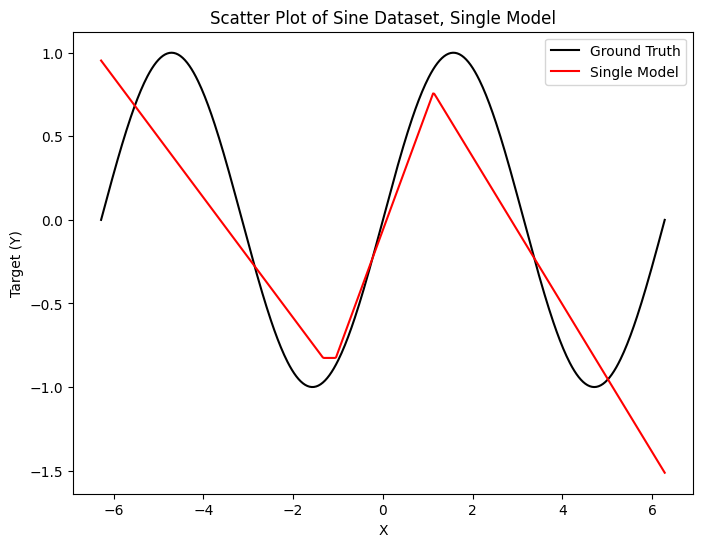

In [6]:
def get_model_output(params, dataset):
    model = BiggerNN(n, input_dim, output_dim, hidden_dim)
    # Check if the number of parameters in the list matches the number of model parameters
    if len(standard_params) != len(list(model.parameters())):
        print("The number of parameters in the list does not match the number of model parameters.")
    else:
        # Iterate through the model parameters and assign values from the list
        for model_param, param_value in zip(model.parameters(), params):
            model_param.data = param_value

    model_outputs = []
    for xs in dataset.xs:
        model_outputs.append(model(xs).detach())
    return model_outputs



model_outputs = get_model_output(standard_params, dataset)
    

# Extract the data
xs = dataset.xs
ys = dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
plt.plot(xs, model_outputs, c="red", label="Single Model")
plt.title('Scatter Plot of Sine Dataset, Single Model')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


### Training Deep Ensembles (num_ensemble = 2, 4, 8)

In [7]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 100
num_ensembles = 2
n = 1
input_dim = 1
output_dim = 1
hidden_dim = 8
two_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

num_ensembles = 4
four_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

num_ensembles = 8
eight_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

num_ensembles = 16
sixteen_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.7352)
Average loss 0 tensor(0.4776)
Average loss 0 tensor(0.4370)
Average loss 0 tensor(0.3973)
Average loss 0 tensor(0.3795)
Average loss 0 tensor(0.4252)


  4%|▍         | 4/100 [00:00<00:10,  8.96it/s]

Average loss 0 tensor(0.3468)
Average loss 0 tensor(0.2729)
Average loss 0 tensor(0.2458)
Average loss 0 tensor(0.1889)
Average loss 0 tensor(0.2427)
Average loss 0 tensor(0.2255)


 10%|█         | 10/100 [00:00<00:05, 17.25it/s]

Average loss 0 tensor(0.2839)
Average loss 0 tensor(0.2328)
Average loss 0 tensor(0.2428)
Average loss 0 tensor(0.2014)
Average loss 0 tensor(0.2177)
Average loss 0 tensor(0.1664)


 16%|█▌        | 16/100 [00:01<00:03, 21.41it/s]

Average loss 0 tensor(0.1447)
Average loss 0 tensor(0.1515)
Average loss 0 tensor(0.2126)
Average loss 0 tensor(0.1854)
Average loss 0 tensor(0.1473)
Average loss 0 tensor(0.1341)


 22%|██▏       | 22/100 [00:01<00:03, 23.65it/s]

Average loss 0 tensor(0.1602)
Average loss 0 tensor(0.1342)
Average loss 0 tensor(0.1653)
Average loss 0 tensor(0.1462)
Average loss 0 tensor(0.1471)
Average loss 0 tensor(0.1208)


 28%|██▊       | 28/100 [00:01<00:02, 24.66it/s]

Average loss 0 tensor(0.1234)
Average loss 0 tensor(0.1230)
Average loss 0 tensor(0.1567)
Average loss 0 tensor(0.1195)
Average loss 0 tensor(0.1137)
Average loss 0 tensor(0.1245)


 34%|███▍      | 34/100 [00:01<00:02, 25.20it/s]

Average loss 0 tensor(0.1132)
Average loss 0 tensor(0.1249)
Average loss 0 tensor(0.1359)
Average loss 0 tensor(0.1340)
Average loss 0 tensor(0.1411)
Average loss 0 tensor(0.1180)


 40%|████      | 40/100 [00:01<00:02, 25.32it/s]

Average loss 0 tensor(0.1218)
Average loss 0 tensor(0.1032)
Average loss 0 tensor(0.1137)
Average loss 0 tensor(0.1034)
Average loss 0 tensor(0.1461)
Average loss 0 tensor(0.1220)


 46%|████▌     | 46/100 [00:02<00:02, 25.38it/s]

Average loss 0 tensor(0.1106)
Average loss 0 tensor(0.1073)
Average loss 0 tensor(0.1045)
Average loss 0 tensor(0.1433)
Average loss 0 tensor(0.1108)
Average loss 0 tensor(0.1374)


 52%|█████▏    | 52/100 [00:02<00:01, 25.38it/s]

Average loss 0 tensor(0.1213)
Average loss 0 tensor(0.1142)
Average loss 0 tensor(0.1088)
Average loss 0 tensor(0.1020)
Average loss 0 tensor(0.1027)
Average loss 0 tensor(0.1210)


 58%|█████▊    | 58/100 [00:02<00:01, 25.16it/s]

Average loss 0 tensor(0.1528)
Average loss 0 tensor(0.1637)
Average loss 0 tensor(0.1667)
Average loss 0 tensor(0.2136)
Average loss 0 tensor(0.1846)
Average loss 0 tensor(0.2050)


 64%|██████▍   | 64/100 [00:02<00:01, 25.31it/s]

Average loss 0 tensor(0.1778)
Average loss 0 tensor(0.1859)
Average loss 0 tensor(0.1345)
Average loss 0 tensor(0.1539)
Average loss 0 tensor(0.1378)
Average loss 0 tensor(0.1438)


 70%|███████   | 70/100 [00:03<00:01, 25.49it/s]

Average loss 0 tensor(0.1504)
Average loss 0 tensor(0.1204)
Average loss 0 tensor(0.1144)
Average loss 0 tensor(0.1295)
Average loss 0 tensor(0.1228)
Average loss 0 tensor(0.0970)


 76%|███████▌  | 76/100 [00:03<00:00, 25.52it/s]

Average loss 0 tensor(0.0965)
Average loss 0 tensor(0.0915)
Average loss 0 tensor(0.0976)
Average loss 0 tensor(0.1039)
Average loss 0 tensor(0.1022)
Average loss 0 tensor(0.1053)


 82%|████████▏ | 82/100 [00:03<00:00, 25.62it/s]

Average loss 0 tensor(0.1015)
Average loss 0 tensor(0.1056)
Average loss 0 tensor(0.1069)
Average loss 0 tensor(0.1297)
Average loss 0 tensor(0.1435)
Average loss 0 tensor(0.1265)


 88%|████████▊ | 88/100 [00:03<00:00, 25.70it/s]

Average loss 0 tensor(0.1086)
Average loss 0 tensor(0.1298)
Average loss 0 tensor(0.1382)
Average loss 0 tensor(0.1202)
Average loss 0 tensor(0.1259)
Average loss 0 tensor(0.1109)


 94%|█████████▍| 94/100 [00:04<00:00, 25.77it/s]

Average loss 0 tensor(0.1005)
Average loss 0 tensor(0.0987)
Average loss 0 tensor(0.0997)
Average loss 0 tensor(0.1072)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.5771)
Average loss 0 tensor(0.4362)
Average loss 0 tensor(0.3907)
Average loss 0 tensor(0.3521)


  3%|▎         | 3/100 [00:00<00:16,  6.02it/s]

Average loss 0 tensor(0.3631)
Average loss 0 tensor(0.3544)
Average loss 0 tensor(0.3432)


  7%|▋         | 7/100 [00:00<00:08, 10.40it/s]

Average loss 0 tensor(0.3336)
Average loss 0 tensor(0.3026)
Average loss 0 tensor(0.2599)


 11%|█         | 11/100 [00:01<00:07, 12.47it/s]

Average loss 0 tensor(0.2344)
Average loss 0 tensor(0.2284)
Average loss 0 tensor(0.1738)


 15%|█▌        | 15/100 [00:01<00:06, 13.37it/s]

Average loss 0 tensor(0.2574)
Average loss 0 tensor(0.2836)
Average loss 0 tensor(0.2164)
Average loss 0 tensor(0.2054)
Average loss 0 tensor(0.2100)
Average loss 0 tensor(0.1986)


 19%|█▉        | 19/100 [00:01<00:05, 13.97it/s]

Average loss 0 tensor(0.2188)
Average loss 0 tensor(0.2452)
Average loss 0 tensor(0.1914)


 23%|██▎       | 23/100 [00:01<00:05, 14.04it/s]

Average loss 0 tensor(0.1814)
Average loss 0 tensor(0.1617)
Average loss 0 tensor(0.1907)


 27%|██▋       | 27/100 [00:02<00:05, 14.15it/s]

Average loss 0 tensor(0.1611)
Average loss 0 tensor(0.1542)
Average loss 0 tensor(0.1595)
Average loss 0 tensor(0.1581)
Average loss 0 tensor(0.1504)
Average loss 0 tensor(0.1648)


 31%|███       | 31/100 [00:02<00:04, 14.18it/s]

Average loss 0 tensor(0.1948)
Average loss 0 tensor(0.2593)
Average loss 0 tensor(0.2451)


 35%|███▌      | 35/100 [00:02<00:04, 14.23it/s]

Average loss 0 tensor(0.2368)
Average loss 0 tensor(0.2220)
Average loss 0 tensor(0.1902)


 39%|███▉      | 39/100 [00:03<00:04, 14.49it/s]

Average loss 0 tensor(0.1661)
Average loss 0 tensor(0.1549)
Average loss 0 tensor(0.1511)
Average loss 0 tensor(0.1766)
Average loss 0 tensor(0.2105)
Average loss 0 tensor(0.1877)


 43%|████▎     | 43/100 [00:03<00:03, 14.28it/s]

Average loss 0 tensor(0.1918)
Average loss 0 tensor(0.1761)
Average loss 0 tensor(0.1592)


 47%|████▋     | 47/100 [00:03<00:03, 14.30it/s]

Average loss 0 tensor(0.1563)
Average loss 0 tensor(0.2065)
Average loss 0 tensor(0.1733)


 51%|█████     | 51/100 [00:03<00:03, 14.25it/s]

Average loss 0 tensor(0.2174)
Average loss 0 tensor(0.2556)
Average loss 0 tensor(0.1913)
Average loss 0 tensor(0.1757)
Average loss 0 tensor(0.1773)
Average loss 0 tensor(0.1549)


 55%|█████▌    | 55/100 [00:04<00:03, 14.11it/s]

Average loss 0 tensor(0.1589)
Average loss 0 tensor(0.1723)
Average loss 0 tensor(0.1650)


 59%|█████▉    | 59/100 [00:04<00:02, 14.18it/s]

Average loss 0 tensor(0.1522)
Average loss 0 tensor(0.1550)
Average loss 0 tensor(0.1684)


 63%|██████▎   | 63/100 [00:04<00:02, 14.26it/s]

Average loss 0 tensor(0.1707)
Average loss 0 tensor(0.1708)
Average loss 0 tensor(0.1654)
Average loss 0 tensor(0.1671)
Average loss 0 tensor(0.1665)
Average loss 0 tensor(0.1769)


 67%|██████▋   | 67/100 [00:05<00:02, 14.27it/s]

Average loss 0 tensor(0.1849)
Average loss 0 tensor(0.1583)
Average loss 0 tensor(0.1682)


 71%|███████   | 71/100 [00:05<00:01, 14.58it/s]

Average loss 0 tensor(0.1509)
Average loss 0 tensor(0.1562)
Average loss 0 tensor(0.1632)


 75%|███████▌  | 75/100 [00:05<00:01, 14.40it/s]

Average loss 0 tensor(0.1801)
Average loss 0 tensor(0.1724)
Average loss 0 tensor(0.1733)
Average loss 0 tensor(0.1641)
Average loss 0 tensor(0.1709)
Average loss 0 tensor(0.1612)


 79%|███████▉  | 79/100 [00:05<00:01, 14.33it/s]

Average loss 0 tensor(0.1564)
Average loss 0 tensor(0.1758)
Average loss 0 tensor(0.2183)


 83%|████████▎ | 83/100 [00:06<00:01, 14.31it/s]

Average loss 0 tensor(0.2014)
Average loss 0 tensor(0.1834)
Average loss 0 tensor(0.1782)


 87%|████████▋ | 87/100 [00:06<00:00, 14.29it/s]

Average loss 0 tensor(0.1670)
Average loss 0 tensor(0.1571)
Average loss 0 tensor(0.1631)
Average loss 0 tensor(0.1757)
Average loss 0 tensor(0.2178)
Average loss 0 tensor(0.2381)


 91%|█████████ | 91/100 [00:06<00:00, 14.35it/s]

Average loss 0 tensor(0.2607)
Average loss 0 tensor(0.2097)
Average loss 0 tensor(0.1924)


 95%|█████████▌| 95/100 [00:07<00:00, 14.28it/s]

Average loss 0 tensor(0.1782)
Average loss 0 tensor(0.1698)
Average loss 0 tensor(0.1715)


 99%|█████████▉| 99/100 [00:07<00:00, 14.26it/s]

Average loss 0 tensor(0.1831)
Average loss 0 tensor(0.1920)
Average loss 0 tensor(0.1741)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.7166)


  1%|          | 1/100 [00:00<00:57,  1.71it/s]

Average loss 0 tensor(0.6018)


  2%|▏         | 2/100 [00:00<00:35,  2.77it/s]

Average loss 0 tensor(0.5176)


  3%|▎         | 3/100 [00:00<00:27,  3.47it/s]

Average loss 0 tensor(0.5262)


  4%|▍         | 4/100 [00:01<00:24,  3.91it/s]

Average loss 0 tensor(0.5210)


  5%|▌         | 5/100 [00:01<00:22,  4.23it/s]

Average loss 0 tensor(0.5751)


  6%|▌         | 6/100 [00:01<00:21,  4.44it/s]

Average loss 0 tensor(0.5186)


  7%|▋         | 7/100 [00:01<00:20,  4.56it/s]

Average loss 0 tensor(0.5147)


  8%|▊         | 8/100 [00:02<00:19,  4.65it/s]

Average loss 0 tensor(0.5136)


  9%|▉         | 9/100 [00:02<00:19,  4.73it/s]

Average loss 0 tensor(0.5701)


 10%|█         | 10/100 [00:02<00:18,  4.78it/s]

Average loss 0 tensor(0.5615)


 11%|█         | 11/100 [00:02<00:18,  4.83it/s]

Average loss 0 tensor(0.6703)


 12%|█▏        | 12/100 [00:02<00:18,  4.85it/s]

Average loss 0 tensor(0.5556)


 13%|█▎        | 13/100 [00:03<00:17,  4.86it/s]

Average loss 0 tensor(0.5567)


 14%|█▍        | 14/100 [00:03<00:17,  4.87it/s]

Average loss 0 tensor(0.5509)


 15%|█▌        | 15/100 [00:03<00:17,  4.85it/s]

Average loss 0 tensor(0.5158)


 16%|█▌        | 16/100 [00:03<00:17,  4.85it/s]

Average loss 0 tensor(0.5481)


 17%|█▋        | 17/100 [00:03<00:17,  4.85it/s]

Average loss 0 tensor(0.7244)


 18%|█▊        | 18/100 [00:04<00:16,  4.85it/s]

Average loss 0 tensor(0.7452)


 19%|█▉        | 19/100 [00:04<00:16,  4.84it/s]

Average loss 0 tensor(0.5838)


 20%|██        | 20/100 [00:04<00:16,  4.86it/s]

Average loss 0 tensor(0.5197)


 21%|██        | 21/100 [00:04<00:16,  4.88it/s]

Average loss 0 tensor(1.0482)


 22%|██▏       | 22/100 [00:04<00:16,  4.86it/s]

Average loss 0 tensor(0.6597)


 23%|██▎       | 23/100 [00:05<00:15,  4.85it/s]

Average loss 0 tensor(0.5804)


 24%|██▍       | 24/100 [00:05<00:15,  4.86it/s]

Average loss 0 tensor(0.5372)


 25%|██▌       | 25/100 [00:05<00:15,  4.86it/s]

Average loss 0 tensor(0.7958)


 26%|██▌       | 26/100 [00:05<00:15,  4.87it/s]

Average loss 0 tensor(0.5347)


 27%|██▋       | 27/100 [00:05<00:14,  4.87it/s]

Average loss 0 tensor(0.5255)


 28%|██▊       | 28/100 [00:06<00:14,  4.85it/s]

Average loss 0 tensor(0.6404)


 29%|██▉       | 29/100 [00:06<00:14,  4.85it/s]

Average loss 0 tensor(0.7658)


 30%|███       | 30/100 [00:06<00:14,  4.87it/s]

Average loss 0 tensor(0.5732)


 31%|███       | 31/100 [00:06<00:14,  4.86it/s]

Average loss 0 tensor(0.5982)


 32%|███▏      | 32/100 [00:06<00:14,  4.86it/s]

Average loss 0 tensor(0.5932)


 33%|███▎      | 33/100 [00:07<00:13,  4.87it/s]

Average loss 0 tensor(0.5632)


 34%|███▍      | 34/100 [00:07<00:13,  4.90it/s]

Average loss 0 tensor(0.5508)


 35%|███▌      | 35/100 [00:07<00:13,  4.90it/s]

Average loss 0 tensor(0.5498)


 36%|███▌      | 36/100 [00:07<00:13,  4.87it/s]

Average loss 0 tensor(0.5449)


 37%|███▋      | 37/100 [00:07<00:12,  4.88it/s]

Average loss 0 tensor(0.6337)


 38%|███▊      | 38/100 [00:08<00:12,  4.87it/s]

Average loss 0 tensor(0.5634)


 39%|███▉      | 39/100 [00:08<00:12,  4.88it/s]

Average loss 0 tensor(0.5704)


 40%|████      | 40/100 [00:08<00:12,  4.89it/s]

Average loss 0 tensor(0.8496)


 41%|████      | 41/100 [00:08<00:12,  4.88it/s]

Average loss 0 tensor(0.5916)


 42%|████▏     | 42/100 [00:08<00:11,  4.87it/s]

Average loss 0 tensor(0.6225)


 43%|████▎     | 43/100 [00:09<00:11,  4.87it/s]

Average loss 0 tensor(0.6696)


 44%|████▍     | 44/100 [00:09<00:11,  4.89it/s]

Average loss 0 tensor(0.6561)


 45%|████▌     | 45/100 [00:09<00:11,  4.91it/s]

Average loss 0 tensor(0.6394)


 46%|████▌     | 46/100 [00:09<00:11,  4.89it/s]

Average loss 0 tensor(0.6628)


 47%|████▋     | 47/100 [00:10<00:10,  4.91it/s]

Average loss 0 tensor(0.6711)


 48%|████▊     | 48/100 [00:10<00:10,  4.90it/s]

Average loss 0 tensor(0.6181)


 49%|████▉     | 49/100 [00:10<00:10,  4.89it/s]

Average loss 0 tensor(0.6633)


 50%|█████     | 50/100 [00:10<00:10,  4.89it/s]

Average loss 0 tensor(0.6703)


 51%|█████     | 51/100 [00:10<00:10,  4.89it/s]

Average loss 0 tensor(0.5885)


 52%|█████▏    | 52/100 [00:11<00:09,  4.87it/s]

Average loss 0 tensor(0.6450)


 53%|█████▎    | 53/100 [00:11<00:09,  4.87it/s]

Average loss 0 tensor(0.6453)


 54%|█████▍    | 54/100 [00:11<00:09,  4.88it/s]

Average loss 0 tensor(1.1937)


 55%|█████▌    | 55/100 [00:11<00:09,  4.88it/s]

Average loss 0 tensor(1.0986)


 56%|█████▌    | 56/100 [00:11<00:09,  4.86it/s]

Average loss 0 tensor(1.1908)


 57%|█████▋    | 57/100 [00:12<00:08,  4.87it/s]

Average loss 0 tensor(1.1805)


 58%|█████▊    | 58/100 [00:12<00:08,  4.87it/s]

Average loss 0 tensor(1.3637)


 59%|█████▉    | 59/100 [00:12<00:08,  4.88it/s]

Average loss 0 tensor(1.2037)


 60%|██████    | 60/100 [00:12<00:08,  4.88it/s]

Average loss 0 tensor(0.9544)


 61%|██████    | 61/100 [00:12<00:08,  4.87it/s]

Average loss 0 tensor(0.7710)


 62%|██████▏   | 62/100 [00:13<00:07,  4.87it/s]

Average loss 0 tensor(0.8882)


 63%|██████▎   | 63/100 [00:13<00:07,  4.85it/s]

Average loss 0 tensor(0.5932)


 64%|██████▍   | 64/100 [00:13<00:07,  4.84it/s]

Average loss 0 tensor(0.5854)


 65%|██████▌   | 65/100 [00:13<00:07,  4.83it/s]

Average loss 0 tensor(0.6214)


 66%|██████▌   | 66/100 [00:13<00:07,  4.82it/s]

Average loss 0 tensor(0.6025)


 67%|██████▋   | 67/100 [00:14<00:06,  4.83it/s]

Average loss 0 tensor(0.6011)


 68%|██████▊   | 68/100 [00:14<00:06,  4.83it/s]

Average loss 0 tensor(0.6051)


 69%|██████▉   | 69/100 [00:14<00:06,  4.85it/s]

Average loss 0 tensor(0.5986)


 70%|███████   | 70/100 [00:14<00:06,  4.87it/s]

Average loss 0 tensor(0.6568)


 71%|███████   | 71/100 [00:14<00:05,  4.87it/s]

Average loss 0 tensor(0.7860)


 72%|███████▏  | 72/100 [00:15<00:05,  4.86it/s]

Average loss 0 tensor(0.9326)
Average loss 0 tensor(0.8412)


 74%|███████▍  | 74/100 [00:15<00:05,  5.04it/s]

Average loss 0 tensor(0.8366)
Average loss 0 

 75%|███████▌  | 75/100 [00:15<00:04,  5.03it/s]

tensor(0.7421)
Average loss 0 

 77%|███████▋  | 77/100 [00:16<00:04,  4.99it/s]

tensor(0.7237)
Average loss 0 tensor(0.6129)


 78%|███████▊  | 78/100 [00:16<00:04,  4.98it/s]

Average loss 0 tensor(0.6476)


 79%|███████▉  | 79/100 [00:16<00:04,  4.94it/s]

Average loss 0 tensor(0.6278)


 80%|████████  | 80/100 [00:16<00:04,  4.93it/s]

Average loss 0 tensor(0.5731)


 81%|████████  | 81/100 [00:16<00:03,  4.94it/s]

Average loss 0 tensor(0.6090)


 82%|████████▏ | 82/100 [00:17<00:03,  4.92it/s]

Average loss 0 tensor(0.5823)


 83%|████████▎ | 83/100 [00:17<00:03,  4.91it/s]

Average loss 0 tensor(0.5919)


 84%|████████▍ | 84/100 [00:17<00:03,  4.90it/s]

Average loss 0 tensor(0.5698)


 85%|████████▌ | 85/100 [00:17<00:03,  4.91it/s]

Average loss 0 tensor(0.6054)


 86%|████████▌ | 86/100 [00:17<00:02,  4.88it/s]

Average loss 0 tensor(0.5749)


 87%|████████▋ | 87/100 [00:18<00:02,  4.87it/s]

Average loss 0 tensor(0.5288)


 88%|████████▊ | 88/100 [00:18<00:02,  4.88it/s]

Average loss 0 tensor(0.7769)


 89%|████████▉ | 89/100 [00:18<00:02,  4.89it/s]

Average loss 0 tensor(1.1398)


 90%|█████████ | 90/100 [00:18<00:02,  4.87it/s]

Average loss 0 tensor(1.1613)


 91%|█████████ | 91/100 [00:19<00:01,  4.88it/s]

Average loss 0 tensor(1.0735)


 92%|█████████▏| 92/100 [00:19<00:01,  4.89it/s]

Average loss 0 tensor(0.7939)


 93%|█████████▎| 93/100 [00:19<00:01,  4.85it/s]

Average loss 0 tensor(0.8946)


 94%|█████████▍| 94/100 [00:19<00:01,  4.88it/s]

Average loss 0 tensor(0.9462)
Average loss 0 

 95%|█████████▌| 95/100 [00:19<00:01,  4.88it/s]

tensor(0.8288)


 96%|█████████▌| 96/100 [00:20<00:00,  4.91it/s]

Average loss 0 tensor(0.6791)


 97%|█████████▋| 97/100 [00:20<00:00,  4.88it/s]

Average loss 0 tensor(0.5194)


 98%|█████████▊| 98/100 [00:20<00:00,  4.90it/s]

Average loss 0 tensor(0.7999)


 99%|█████████▉| 99/100 [00:20<00:00,  4.90it/s]

Average loss 0 tensor(0.5410)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(1.5503)


  1%|          | 1/100 [00:00<01:18,  1.25it/s]

Average loss 0 tensor(0.5891)


  2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

Average loss 0 tensor(0.5896)


  3%|▎         | 3/100 [00:01<00:48,  2.00it/s]

Average loss 0 tensor(0.5853)


  4%|▍         | 4/100 [00:02<00:44,  2.15it/s]

Average loss 0 tensor(0.5128)


  5%|▌         | 5/100 [00:02<00:42,  2.23it/s]

Average loss 0 tensor(0.5134)


  6%|▌         | 6/100 [00:02<00:41,  2.29it/s]

Average loss 0 tensor(0.4763)


  7%|▋         | 7/100 [00:03<00:39,  2.33it/s]

Average loss 0 tensor(0.5421)


  8%|▊         | 8/100 [00:03<00:38,  2.36it/s]

Average loss 0 tensor(0.5331)


  9%|▉         | 9/100 [00:04<00:38,  2.38it/s]

Average loss 0 tensor(0.5511)


 10%|█         | 10/100 [00:04<00:37,  2.39it/s]

Average loss 0 tensor(0.5037)


 11%|█         | 11/100 [00:04<00:37,  2.40it/s]

Average loss 0 tensor(0.4843)


 12%|█▏        | 12/100 [00:05<00:36,  2.40it/s]

Average loss 0 tensor(0.6989)


 13%|█▎        | 13/100 [00:05<00:36,  2.40it/s]

Average loss 0 tensor(0.6384)


 14%|█▍        | 14/100 [00:06<00:35,  2.41it/s]

Average loss 0 tensor(0.5022)


 15%|█▌        | 15/100 [00:06<00:35,  2.41it/s]

Average loss 0 tensor(0.4511)


 16%|█▌        | 16/100 [00:07<00:34,  2.42it/s]

Average loss 0 tensor(0.5211)


 17%|█▋        | 17/100 [00:07<00:34,  2.42it/s]

Average loss 0 tensor(0.5205)


 18%|█▊        | 18/100 [00:07<00:33,  2.42it/s]

Average loss 0 tensor(0.6339)


 19%|█▉        | 19/100 [00:08<00:33,  2.42it/s]

Average loss 0 tensor(0.5911)


 20%|██        | 20/100 [00:08<00:33,  2.41it/s]

Average loss 0 tensor(0.6195)


 21%|██        | 21/100 [00:09<00:32,  2.40it/s]

Average loss 0 tensor(0.6239)


 22%|██▏       | 22/100 [00:09<00:32,  2.40it/s]

Average loss 0 tensor(0.5963)


 23%|██▎       | 23/100 [00:09<00:32,  2.41it/s]

Average loss 0 tensor(0.6784)


 24%|██▍       | 24/100 [00:10<00:31,  2.41it/s]

Average loss 0 tensor(0.5155)


 25%|██▌       | 25/100 [00:10<00:31,  2.41it/s]

Average loss 0 tensor(0.5355)


 26%|██▌       | 26/100 [00:11<00:30,  2.41it/s]

Average loss 0 tensor(0.7142)


 27%|██▋       | 27/100 [00:11<00:30,  2.41it/s]

Average loss 0 tensor(0.6758)


 28%|██▊       | 28/100 [00:11<00:29,  2.41it/s]

Average loss 0 tensor(0.6180)


 29%|██▉       | 29/100 [00:12<00:29,  2.42it/s]

Average loss 0 tensor(0.4827)


 30%|███       | 30/100 [00:12<00:28,  2.41it/s]

Average loss 0 tensor(0.5342)


 31%|███       | 31/100 [00:13<00:28,  2.42it/s]

Average loss 0 tensor(0.4863)


 32%|███▏      | 32/100 [00:13<00:28,  2.42it/s]

Average loss 0 tensor(0.5690)


 33%|███▎      | 33/100 [00:14<00:27,  2.43it/s]

Average loss 0 tensor(0.4956)


 34%|███▍      | 34/100 [00:14<00:27,  2.43it/s]

Average loss 0 tensor(0.4668)


 35%|███▌      | 35/100 [00:14<00:26,  2.44it/s]

Average loss 0 tensor(0.5588)


 36%|███▌      | 36/100 [00:15<00:26,  2.44it/s]

Average loss 0 tensor(0.4813)


 37%|███▋      | 37/100 [00:15<00:25,  2.43it/s]

Average loss 0 tensor(0.6342)


 38%|███▊      | 38/100 [00:16<00:25,  2.42it/s]

Average loss 0 tensor(0.5939)


 39%|███▉      | 39/100 [00:16<00:25,  2.42it/s]

Average loss 0 tensor(0.7680)


 40%|████      | 40/100 [00:16<00:24,  2.42it/s]

Average loss 0 tensor(0.5737)


 41%|████      | 41/100 [00:17<00:24,  2.43it/s]

Average loss 0 tensor(0.4949)


 42%|████▏     | 42/100 [00:17<00:23,  2.43it/s]

Average loss 0 tensor(0.6392)


 43%|████▎     | 43/100 [00:18<00:23,  2.42it/s]

Average loss 0 tensor(0.5478)


 44%|████▍     | 44/100 [00:18<00:23,  2.41it/s]

Average loss 0 tensor(1.0351)


 45%|████▌     | 45/100 [00:19<00:22,  2.41it/s]

Average loss 0 tensor(0.7859)


 46%|████▌     | 46/100 [00:19<00:22,  2.41it/s]

Average loss 0 tensor(0.5842)


 47%|████▋     | 47/100 [00:19<00:21,  2.41it/s]

Average loss 0 tensor(0.5438)


 48%|████▊     | 48/100 [00:20<00:21,  2.41it/s]

Average loss 0 tensor(0.7119)


 49%|████▉     | 49/100 [00:20<00:21,  2.41it/s]

Average loss 0 tensor(0.5140)


 50%|█████     | 50/100 [00:21<00:20,  2.41it/s]

Average loss 0 tensor(0.5955)


 51%|█████     | 51/100 [00:21<00:20,  2.40it/s]

Average loss 0 tensor(0.5434)


 52%|█████▏    | 52/100 [00:21<00:19,  2.41it/s]

Average loss 0 tensor(0.5582)


 53%|█████▎    | 53/100 [00:22<00:20,  2.33it/s]

Average loss 0 tensor(0.5544)


 54%|█████▍    | 54/100 [00:22<00:19,  2.35it/s]

Average loss 0 tensor(0.5218)


 55%|█████▌    | 55/100 [00:23<00:18,  2.37it/s]

Average loss 0 tensor(0.6806)


 56%|█████▌    | 56/100 [00:23<00:18,  2.38it/s]

Average loss 0 tensor(0.6152)


 57%|█████▋    | 57/100 [00:24<00:18,  2.38it/s]

Average loss 0 tensor(0.6135)


 58%|█████▊    | 58/100 [00:24<00:17,  2.39it/s]

Average loss 0 tensor(0.6008)


 59%|█████▉    | 59/100 [00:24<00:17,  2.40it/s]

Average loss 0 tensor(0.5603)


 60%|██████    | 60/100 [00:25<00:16,  2.40it/s]

Average loss 0 tensor(0.6150)


 61%|██████    | 61/100 [00:25<00:16,  2.41it/s]

Average loss 0 tensor(0.5341)


 62%|██████▏   | 62/100 [00:26<00:15,  2.42it/s]

Average loss 0 tensor(0.5472)


 63%|██████▎   | 63/100 [00:26<00:15,  2.42it/s]

Average loss 0 tensor(0.5370)


 64%|██████▍   | 64/100 [00:26<00:14,  2.42it/s]

Average loss 0 tensor(0.5211)


 65%|██████▌   | 65/100 [00:27<00:14,  2.41it/s]

Average loss 0 tensor(0.6029)


 66%|██████▌   | 66/100 [00:27<00:14,  2.41it/s]

Average loss 0 tensor(0.5258)


 67%|██████▋   | 67/100 [00:28<00:13,  2.42it/s]

Average loss 0 tensor(0.8919)


 68%|██████▊   | 68/100 [00:28<00:13,  2.41it/s]

Average loss 0 tensor(0.5937)


 69%|██████▉   | 69/100 [00:29<00:12,  2.41it/s]

Average loss 0 tensor(0.8915)


 70%|███████   | 70/100 [00:29<00:12,  2.41it/s]

Average loss 0 tensor(0.6922)


 71%|███████   | 71/100 [00:29<00:12,  2.41it/s]

Average loss 0 tensor(0.6565)


 72%|███████▏  | 72/100 [00:30<00:11,  2.41it/s]

Average loss 0 tensor(0.6681)


 73%|███████▎  | 73/100 [00:30<00:11,  2.41it/s]

Average loss 0 tensor(0.5490)


 74%|███████▍  | 74/100 [00:31<00:10,  2.41it/s]

Average loss 0 tensor(0.5528)


 75%|███████▌  | 75/100 [00:31<00:10,  2.41it/s]

Average loss 0 tensor(0.5610)


 76%|███████▌  | 76/100 [00:31<00:09,  2.41it/s]

Average loss 0 tensor(0.6145)


 77%|███████▋  | 77/100 [00:32<00:09,  2.42it/s]

Average loss 0 tensor(0.6946)


 78%|███████▊  | 78/100 [00:32<00:09,  2.40it/s]

Average loss 0 tensor(0.7030)


 79%|███████▉  | 79/100 [00:33<00:08,  2.41it/s]

Average loss 0 tensor(0.5929)


 80%|████████  | 80/100 [00:33<00:08,  2.41it/s]

Average loss 0 tensor(0.5264)


 81%|████████  | 81/100 [00:33<00:07,  2.41it/s]

Average loss 0 tensor(0.5393)


 82%|████████▏ | 82/100 [00:34<00:07,  2.40it/s]

Average loss 0 tensor(0.5314)


 83%|████████▎ | 83/100 [00:34<00:07,  2.39it/s]

Average loss 0 tensor(0.6466)


 84%|████████▍ | 84/100 [00:35<00:06,  2.39it/s]

Average loss 0 tensor(0.5199)


 85%|████████▌ | 85/100 [00:35<00:06,  2.40it/s]

Average loss 0 tensor(0.5910)


 86%|████████▌ | 86/100 [00:36<00:05,  2.41it/s]

Average loss 0 tensor(0.8246)


 87%|████████▋ | 87/100 [00:36<00:05,  2.41it/s]

Average loss 0 tensor(0.9173)


 88%|████████▊ | 88/100 [00:36<00:04,  2.41it/s]

Average loss 0 tensor(1.0637)


 89%|████████▉ | 89/100 [00:37<00:04,  2.41it/s]

Average loss 0 tensor(0.8994)


 90%|█████████ | 90/100 [00:37<00:04,  2.42it/s]

Average loss 0 tensor(0.6401)


 91%|█████████ | 91/100 [00:38<00:03,  2.42it/s]

Average loss 0 tensor(0.7667)


 92%|█████████▏| 92/100 [00:38<00:03,  2.42it/s]

Average loss 0 tensor(0.5457)


 93%|█████████▎| 93/100 [00:38<00:02,  2.41it/s]

Average loss 0 tensor(0.7239)


 94%|█████████▍| 94/100 [00:39<00:02,  2.41it/s]

Average loss 0 tensor(0.6169)


 95%|█████████▌| 95/100 [00:39<00:02,  2.41it/s]

Average loss 0 tensor(0.6088)


 96%|█████████▌| 96/100 [00:40<00:01,  2.41it/s]

Average loss 0 tensor(0.5220)


 97%|█████████▋| 97/100 [00:40<00:01,  2.40it/s]

Average loss 0 tensor(0.4801)


 98%|█████████▊| 98/100 [00:41<00:00,  2.40it/s]

Average loss 0 tensor(0.4864)


 99%|█████████▉| 99/100 [00:41<00:00,  2.41it/s]

Average loss 0 tensor(0.4680)


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


The goal of deep ensembles is to get a better approximation of the posterior through averaging multiple runs of the same nueral network. Thus we must aggregate and average the predictions of each model to achieve this goal. First we initialize num_ensemble models with the parameters saved from training. We will save each model in the list, models.

In [8]:
def get_ensemble_models(paramList, num_ensembles):
    models = []
    for i in range(num_ensembles):
        model = BiggerNN(n, input_dim, output_dim, hidden_dim)
        
        # Check if the number of parameters in the list matches the number of model parameters
        if len(paramList[i]) != len(list(model.parameters())):
            print("The number of parameters in the list does not match the number of model parameters.")
        else:
            # Iterate through the model parameters and assign values from the list
            for model_param, param_value in zip(model.parameters(), paramList[i]):
                model_param.data = param_value

        models.append(model)
    return models

two_particle_models = get_ensemble_models(two_particle_params, 2)
four_particle_models = get_ensemble_models(four_particle_params, 4)
eight_particle_models = get_ensemble_models(eight_particle_params, 8)
sixteen_particle_models = get_ensemble_models(sixteen_particle_params, 16)

Then we loop through each model and save its output to a list of model_outputs. This is so that we can calculate an average over all model.

In [9]:
def get_ensemble_output(modelList, dataset, num_ensembles):
    outputs = []
    for i in range(num_ensembles):
        model_i_output = []
        for xs in dataset.xs:
            model_i_output.append(modelList[i](xs).detach())
        outputs.append(model_i_output)
    return outputs

def get_ensemble_average(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the average tensors
    averages = []

    # Calculate the average for each list of tensors and add them to the 'averages' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        average_tensor = torch.mean(stacked_tensor, dim=0)
        averages.append(average_tensor)
    return averages

two_model_outputs = get_ensemble_output(two_particle_models, dataset, 2)
four_model_outputs = get_ensemble_output(four_particle_models, dataset, 4)
eight_model_outputs = get_ensemble_output(eight_particle_models, dataset, 8)
sixteen_model_outputs = get_ensemble_output(sixteen_particle_models, dataset, 16)

Then we stack our output tensors and compute the average

In [10]:
def get_ensemble_average(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the average tensors
    averages = []

    # Calculate the average for each list of tensors and add them to the 'averages' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        average_tensor = torch.mean(stacked_tensor, dim=0)
        averages.append(average_tensor)
    return averages

two_model_averages = get_ensemble_average(two_model_outputs)
four_model_averages = get_ensemble_average(four_model_outputs)
eight_model_averages = get_ensemble_average(eight_model_outputs)
sixteen_model_averages = get_ensemble_average(sixteen_model_outputs)

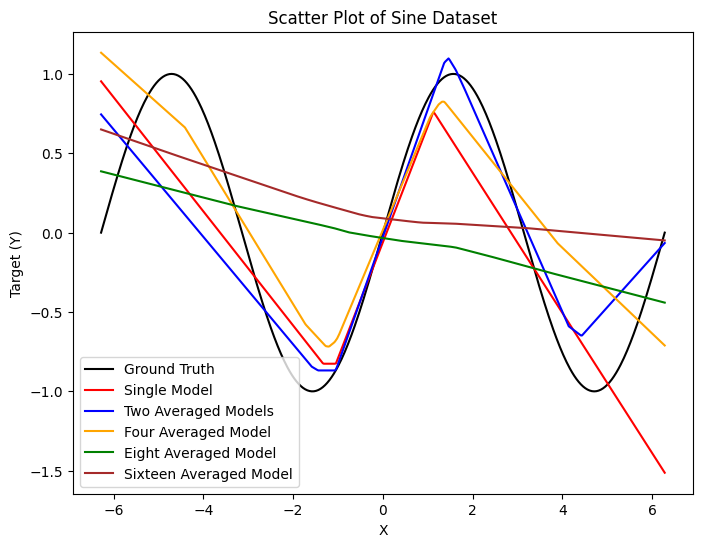

In [11]:
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
# for i in range(num_ensembles):
#     plt.scatter(xs, model_outputs[i], label="Model " + str(i))
plt.plot(xs, model_outputs, c="red", label="Single Model")
plt.plot(xs, two_model_averages, c="blue", label="Two Averaged Models")
plt.plot(xs, four_model_averages, c="orange", label="Four Averaged Model")
plt.plot(xs, eight_model_averages, c="green", label="Eight Averaged Model")
plt.plot(xs, sixteen_model_averages, c="brown", label="Sixteen Averaged Model")
plt.title('Scatter Plot of Sine Dataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


# Out of Sample Testing
Now we will test our models on data outside of the training set [-2pi, 4pi]. This can show us how robust our models are when dealing with data that does not look like the training set.

Create new dataset from [-2pi, 4pi]

In [12]:
D = 1
batch_size = 128
N = 1
oos_dataset = SineDataset(batch_size, N, D, -4, 4)

In [13]:
single_model_outputs = get_model_output(standard_params, oos_dataset)
two_model_outputs = get_ensemble_output(two_particle_models, oos_dataset, 2)
four_model_outputs = get_ensemble_output(four_particle_models, oos_dataset, 4)
eight_model_outputs = get_ensemble_output(eight_particle_models, oos_dataset, 8)
sixteen_model_outputs = get_ensemble_output(sixteen_particle_models, oos_dataset, 16)

two_model_averages = get_ensemble_average(two_model_outputs)
four_model_averages = get_ensemble_average(four_model_outputs)
eight_model_averages = get_ensemble_average(eight_model_outputs)
sixteen_model_averages = get_ensemble_average(sixteen_model_outputs)

# Plotting Out of Sample Predictions

Datapoints within the two dotted black lines are within the training set.

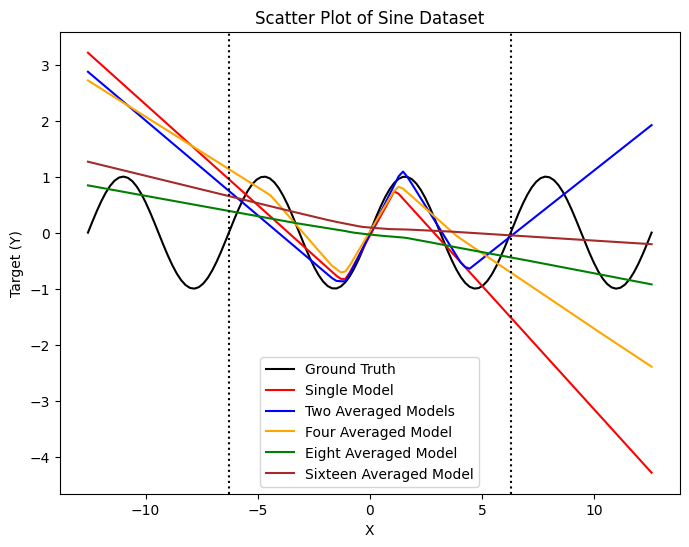

In [14]:
# Extract the data
xs = oos_dataset.xs
ys = oos_dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
# for i in range(num_ensembles):
#     plt.scatter(xs, model_outputs[i], label="Model " + str(i))
plt.plot(xs, single_model_outputs, c="red", label="Single Model")
plt.plot(xs, two_model_averages, c="blue", label="Two Averaged Models")
plt.plot(xs, four_model_averages, c="orange", label="Four Averaged Model")
plt.plot(xs, eight_model_averages, c="green", label="Eight Averaged Model")
plt.plot(xs, sixteen_model_averages, c="brown", label="Sixteen Averaged Model")
plt.axvline(x=-2*3.1416, color="black", linestyle="dotted")
plt.axvline(x=2*3.1416, color="black", linestyle="dotted")
plt.title('Scatter Plot of Sine Dataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

References:

[1] A.G. Wilson, P. Izmailov. Bayesian Deep Learning and a Probabilistic Perspective of Generalization. Advances in Neural Information Processing Systems, 2020.